In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Case 1- 모든 단어사용

In [2]:
# Data
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

print(x_train[0])
print(x_test[0])
print(y_train[0])
print(y_test[0])

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324

In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


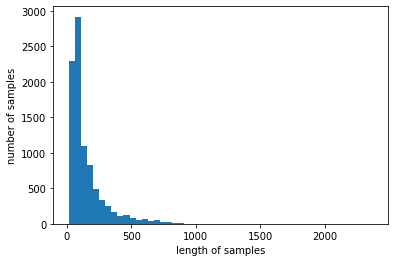

In [6]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

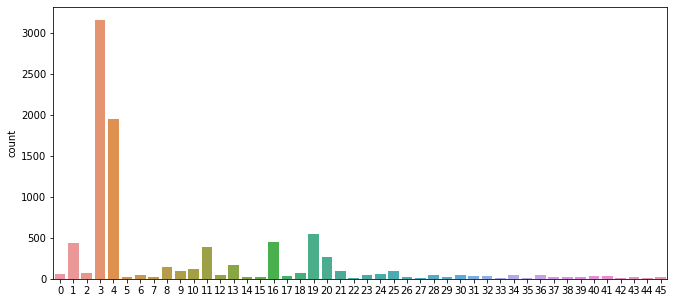

In [7]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


#### preprocessing

In [9]:
decoded_train = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded_train.append(t)

x_train = decoded_train
print(len(x_train))

8982


In [10]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


#### Vectorization

In [11]:
# DTM
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [12]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


#### 1.Naive Bayes

In [13]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [14]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


#### 2. CNB (Complement Naive Bayes Classifier)

In [15]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [16]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


#### 3. Logistic Regression

In [17]:
# 5분 정도 소요

lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [18]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8165627782724845


#### 4. SVM

In [19]:
# 2분

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [20]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7898486197684773


#### 5. Decision Tree

In [21]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [22]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


#### 6. Random Forest

In [23]:
forest = RandomForestClassifier(n_estimators=5, random_state = 0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [24]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


#### 7. GradientBoostingClassifier

In [25]:
# 14분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [26]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


#### 8. Voting

In [27]:
# 12-13분

# 각 분류기 정의
logreg = LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs')
cnb = ComplementNB()
gboost = GradientBoostingClassifier()

# VotingClassifier 생성 (soft voting)
voting_classifier = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('cnb', cnb),
    ('gboost', gboost)
], voting='soft')

# 모델 훈련
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression(max_iter=1000)),
                             ('cnb', ComplementNB()),
                             ('gboost', GradientBoostingClassifier())],
                 voting='soft')

In [28]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8067675868210151


In [ ]:
def show_report(y, pred):
    print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

### Case2-상위 5000개만 사용

In [29]:
# Data
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=None, test_split=0.2)

In [30]:
print('훈련 샘플의 수: {}'.format(len(x_train_5k)))
print('테스트 샘플의 수: {}'.format(len(x_test_5k)))

print(x_train_5k[0])
print(x_test_5k[0])
print(y_train_5k[0])
print(y_test_5k[0])

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324

In [31]:
num_classes = max(y_train_5k) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [32]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


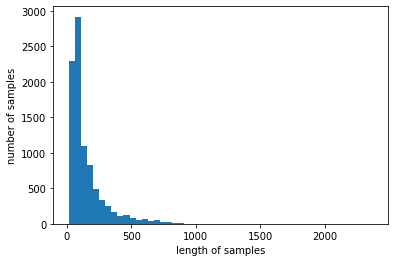

In [33]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_5k)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_5k))/len(x_train_5k)))

plt.hist([len(s) for s in x_train_5k], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

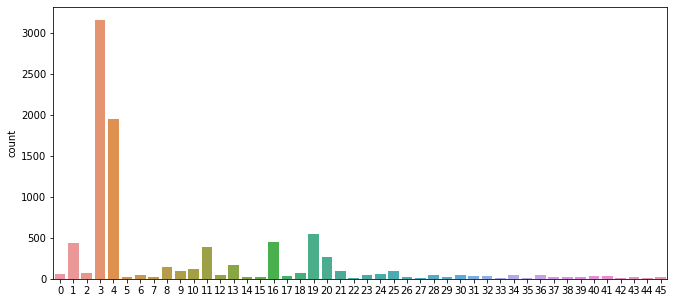

In [34]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train_5k)
plt.show()

In [35]:
unique_elements, counts_elements = np.unique(y_train_5k, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


#### preprocessing

In [37]:
decoded_train = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded_train.append(t)

x_train = decoded_train
print(len(x_train_5k))

8982


In [38]:
decoded_test = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test_5k))

2246


#### Vectorization

In [39]:
# DTM
dtmvector_5k = CountVectorizer()
x_train_5k_dtm = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm.shape)

(8982, 26506)


In [40]:
# TF-IDF
tfidf_5k_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_5k_dtm)
print(tfidfv_5k.shape)

(8982, 26506)


#### 1.Naive Bayes

In [41]:
model = MultinomialNB()
model.fit(tfidfv_5k, y_train_5k)

MultinomialNB()

In [42]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) #테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) #DTM을 TF-IDF 행렬로 변환

predicted_5k = model.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.5997328584149599


#### 2. CNB (Complement Naive Bayes Classifier)

In [43]:
cb = ComplementNB()
cb.fit(tfidfv_5k, y_train_5k)

ComplementNB()

In [44]:
predicted_5k = cb.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.7649154051647373


#### 3. Logistic Regression

In [45]:
# 5분 정도 소요

lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv_5k, y_train_5k)

LogisticRegression(C=10000, max_iter=3000)

In [46]:
predicted = lr.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.8165627782724845


#### 4. SVM

In [47]:
# 2분

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv_5k, y_train_5k)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [48]:
predicted_5k = lsvc.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.7898486197684773


#### 5. Decision Tree

In [49]:
tree_5k = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_5k.fit(tfidfv_5k, y_train_5k)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [50]:
predicted_5k = tree_5k.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.6211041852181657


#### 6. Random Forest

In [51]:
forest = RandomForestClassifier(n_estimators=5, random_state = 0)
forest.fit(tfidfv_5k, y_train_5k)

RandomForestClassifier(n_estimators=5, random_state=0)

In [52]:
predicted_5k = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.6544968833481746


#### 7. GradientBoostingClassifier

In [53]:
# 14분 정도 소요될 수 있습니다.
grbt_5k = GradientBoostingClassifier(random_state=0) # verbose=3
grbt_5k.fit(tfidfv_5k, y_train_5k)

GradientBoostingClassifier(random_state=0)

In [54]:
predicted_5k = grbt.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.7702582368655387


#### 8. Voting

In [55]:
# 12-13분

# 각 분류기 정의
logreg_5k = LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs')
cnb_5k = ComplementNB()
gboost_5k = GradientBoostingClassifier()

# VotingClassifier 생성 (soft voting)
voting_classifier = VotingClassifier(estimators=[
    ('logreg', logreg_5k),
    ('cnb', cnb_5k),
    ('gboost', gboost_5k)
], voting='soft')

# 모델 훈련
voting_classifier.fit(tfidfv_5k, y_train_5k)

VotingClassifier(estimators=[('logreg', LogisticRegression(max_iter=1000)),
                             ('cnb', ComplementNB()),
                             ('gboost', GradientBoostingClassifier())],
                 voting='soft')

In [56]:
predicted_5k = voting_classifier.predict(tfidfv_test_5k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_5k, predicted_5k)) #예측값과 실제값 비교

정확도: 0.804986642920748


In [ ]:
show_report(y, pred)

### Case3- 상위 1000개만 사용

In [58]:
# Data
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)

In [59]:
print('훈련 샘플의 수: {}'.format(len(x_train_1k)))
print('테스트 샘플의 수: {}'.format(len(x_test_1k)))

print(x_train_1k[0])
print(x_test_1k[0])
print(y_train_1k[0])
print(y_test_1k[0])

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 2, 2, 9, 697, 2, 111, 8, 25, 109, 29, 2, 11, 150, 244, 364, 33, 30, 30, 2, 333, 6, 2, 159, 9, 2, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 2, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 2, 966, 2, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 2, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 2, 855, 129, 783, 21, 4, 2, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 2, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]
3
3


In [60]:
num_classes = max(y_train_1k) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [61]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in x_train_1k[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> <unk> revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash <unk> per share this year should be 2 50 to three dlrs reuter 3


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


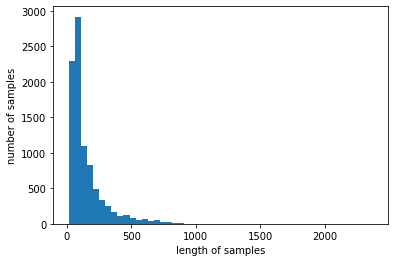

In [62]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_1k)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train_1k)))

plt.hist([len(s) for s in x_train_1k], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

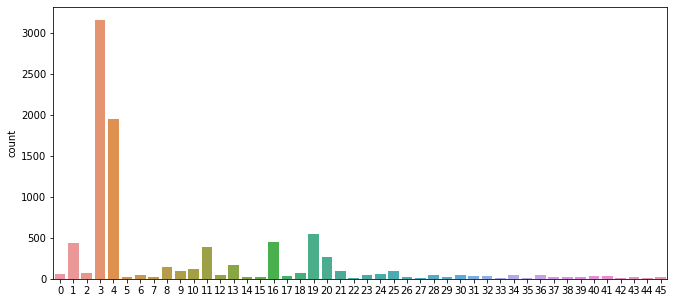

In [63]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train_1k)
plt.show()

In [64]:
unique_elements, counts_elements = np.unique(y_train_1k, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


#### preprocessing

In [65]:
decoded_train = []
for i in range(len(x_train_1k)):
    t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
    decoded_train.append(t)

x_train_1k = decoded_train
print(len(x_train_1k))

8982


In [66]:
decoded_test = []
for i in range(len(x_test_1k)):
    t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
    decoded_test.append(t)

x_test_1k = decoded_test
print(len(x_test_1k))

2246


#### Vectorization

In [67]:
# DTM
dtmvector_1k = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [68]:
# TF-IDF
tfidf_transformer_1k = TfidfTransformer()
tfidfv_1k = tfidf_transformer_1k.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


#### 1.Naive Bayes

In [69]:
model = MultinomialNB()
model.fit(tfidfv, y_train)
x_test_dtm_1k = dtmvector_1k.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer_1k.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted_1k = model.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.6856634016028496


#### 2. CNB (Complement Naive Bayes Classifier)

In [70]:
cb = ComplementNB()
cb.fit(tfidfv_1k, y_train_1k)
predicted_1k = cb.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.7346393588601959


#### 3. Logistic Regression

In [71]:
# 5분 정도 소요

lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv_1k, y_train_1k)
predicted = lr.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.738646482635797


#### 4. SVM

In [72]:
# 2분

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv_1k, y_train_1k)
predicted = lsvc.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.7252894033837934


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### 5. Decision Tree

In [73]:
tree_1k = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_1k.fit(tfidfv_1k, y_train_1k)
predicted_1k = tree_1k.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.6179875333926982


#### 6. Random Forest

In [74]:
forest_1k = RandomForestClassifier(n_estimators=5, random_state = 0)
forest_1k.fit(tfidfv_1k, y_train)
predicted = forest_1k.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.707479964381122


#### 7. GradientBoostingClassifier

In [ ]:
# 14분 정도 소요될 수 있습니다.
grbt_1k = GradientBoostingClassifier(random_state=0) # verbose=3
grbt_1k.fit(tfidfv_1k, y_train_1k)
predicted_1k = grbt.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

#### 8. Voting

In [76]:
# 12-13분

# 각 분류기 정의
logreg_1k = LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs')
cnb_1k = ComplementNB()
gboost_1k = GradientBoostingClassifier()


# VotingClassifier 생성 (soft voting)
voting_classifier = VotingClassifier(estimators=[
    ('logreg', logreg_1k),
    ('cnb', cnb_1k),
    ('gboost', gboost_1k)
], voting='soft')

# 모델 훈련
voting_classifier.fit(tfidfv_1k, y_train_1k)

VotingClassifier(estimators=[('logreg', LogisticRegression(max_iter=1000)),
                             ('cnb', ComplementNB()),
                             ('gboost', GradientBoostingClassifier())],
                 voting='soft')

In [77]:
predicted_1k = voting_classifier.predict(tfidfv_test_1k) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test_1k, predicted_1k)) #예측값과 실제값 비교

정확도: 0.7631344612644702


#### 딥러닝 모델과 비교

In [106]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping



vocab_size=1000
word_vector_dim = 32

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim))
model.add(LSTM(32))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

epochs=20
batch_size=64

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_10 (Dense)             (None, 46)                5934      
Total params: 50,478
Trainable params: 50,478
Non-trainable params: 0
_________________________________________________________________


In [107]:
tfidfv_np = tfidfv.toarray()
tfidfv_test_np = tfidfv_test.toarray()

In [108]:
history_LSTM = model.fit(tfidfv_np,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[es],
                        validation_split=0.2,
                        verbose=1)

Epoch 1/20
113/113 [==============================] - 5s 30ms/step - loss: 2.7340 - accuracy: 0.3351 - val_loss: 2.4130 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 3s 26ms/step - loss: 2.4102 - accuracy: 0.3534 - val_loss: 2.4121 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 3s 27ms/step - loss: 2.4103 - accuracy: 0.3534 - val_loss: 2.4097 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 3s 26ms/step - loss: 2.4110 - accuracy: 0.3534 - val_loss: 2.4088 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 3s 26ms/step - loss: 2.4107 - accuracy: 0.3534 - val_loss: 2.4065 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 3s 26ms/step - loss: 2.4089 - accuracy: 0.3534 - val_loss: 2.4089 - val_accuracy: 0.3450
Epoch 7/20
113/113 [==============================] - 3s 27ms/step - loss: 2.4089 - accuracy: 0.3534 - val_loss: 2.4110 - val_accuracy: 0.3450

상위 1000개일때, 딥러닝으로 나온 f1 score 값이 오히려 낮다. 

** 나중에 해볼거: <br>
- 8가지 머신러닝을 함수로 자동화하기
- case별 모델변수를 다르게 지정해줘서 f-1 score를 plt 또는 df로 결과 비교해보기